In [1]:
import os, sys, platform, yaml, re
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql import DataFrame
from pyspark.sql.types import DoubleType, FloatType, StringType
from pathlib import Path
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.utils.statistics import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# Para reproducibilidad en pandas (no afecta Spark)
np.random.seed(42)

# Preparación

In [2]:
conf_path = str(Path.cwd() / "config" / "ETL_config.yaml")
with open(conf_path, "r") as f:
    CFG = yaml.safe_load(f)

IS_WIN          = platform.system() == "Windows"
CSV_DIR         = CFG["paths"]["csv_base_dir"]["windows" if IS_WIN else "linux"]
PG_URL          = CFG["postgres"]["url"]
PG_USER         = CFG["postgres"]["user"]
PG_PASS         = CFG["postgres"]["pass"]
PG_SCHEMA       = CFG["postgres"]["schema_out"]["schema_name"]
PG_TABLE1       = CFG["postgres"]["schema_out"]["table1"]
PG_TABLE2       = CFG["postgres"]["schema_out"]["table2"]
PG_TABLE3       = CFG["postgres"]["schema_out"]["table3"]
FILES           = CFG["csv"]["files"]
NUM_PARTITIONS  = CFG["csv"]["num_partitions"]
JDBC_BATCHSIZE  = CFG["postgres"]["batchsize"]
JDBC_FETCHSIZE  = CFG["postgres"]["fetchsize"]
SPARK_LOCAL_DIR = CFG["spark"]["local_dirs"]["windows" if IS_WIN else "linux"]
NEO4J_URI  = CFG["neo4j"]["uri"]          # "bolt://localhost:7687"
NEO4J_USER = CFG["neo4j"]["user"]
NEO4J_PASS = CFG["neo4j"]["pass"]
NEO4J_DB   = CFG["neo4j"]["database"]

opts = {
    "url": NEO4J_URI,
    "authentication.type": "basic",
    "authentication.basic.username": NEO4J_USER,
    "authentication.basic.password": NEO4J_PASS,
    "database": NEO4J_DB,
}

os.environ["PYSPARK_PYTHON"] = sys.executable       # usa el Python del kernel actual
os.environ["JAVA_HOME"] = os.environ.get("JAVA_HOME", "/usr/lib/jvm/java-17-openjdk-amd64") #Chequear versión Windows después
Path(SPARK_LOCAL_DIR).mkdir(parents=True, exist_ok=True)


In [3]:
builder = (
    SparkSession.builder
    .master("local[*]")  
    .appName(CFG["spark"]["app_name"])
    .config("spark.sql.shuffle.partitions", str(CFG["spark"]["shuffle_partitions"]))
    .config("spark.driver.memory", CFG["spark"]["driver_memory"])
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.local.dir", SPARK_LOCAL_DIR)   
    #.config("spark.jars.packages", ",".join(CFG["spark"]["local_jars"]["linux"]))
    .config(
        "spark.jars.packages",
        ",".join([
            "org.postgresql:postgresql:42.7.4",
            "org.neo4j:neo4j-connector-apache-spark_2.12:5.3.10_for_spark_3"
        ])
    )
)

spark = builder.getOrCreate()
spark.sparkContext.setLogLevel("WARN")

jdbc_props = {
        "user": PG_USER,
        "password": PG_PASS,
        "driver": "org.postgresql.Driver",
        "fetchsize": str(JDBC_FETCHSIZE)
    }


25/11/17 10:11:14 WARN Utils: Your hostname, AsusMare resolves to a loopback address: 127.0.1.1; using 192.168.31.234 instead (on interface wlp2s0)
25/11/17 10:11:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark-3.5.3-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/felpipe/.ivy2/cache
The jars for the packages stored in: /home/felpipe/.ivy2/jars
org.postgresql#postgresql added as a dependency
org.neo4j#neo4j-connector-apache-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-637aa2af-02d0-4cbe-9a6f-115f9a35855b;1.0
	confs: [default]
	found org.postgresql#postgresql;42.7.4 in central
	found org.checkerframework#checker-qual;3.42.0 in central
	found org.neo4j#neo4j-connector-apache-spark_2.12;5.3.10_for_spark_3 in central
	found org.neo4j#neo4j-connector-apache-spark_2.12_common;5.3.10_for_spark_3 in central
	found org.neo4j#caniuse-core;1.3.0 in local-m2-cache
	found org.neo4j#caniuse-api;1.3.0 in local-m2-cache
	found org.jetbrains.kotlin#kotlin-stdlib;2.1.20 in local-m2-cache
	found org.jetbrains#annotations;13.0 in local-m2-cache
	found org.neo4j#caniuse-neo4j-detection;1.3.0 in local-m2-cache
	found org.neo4j.driver#neo4j-java-driver-slim;4.4.21 in local-m2-cache
	

In [4]:
df_acc = (spark.read.format("jdbc")
        .option("url", PG_URL)
        .option("dbtable", f"{PG_SCHEMA}.{PG_TABLE1}")
        .option("partitionColumn", "account")
        .option("lowerBound", 1)                  
        .option("upperBound", 2000000)
        .option("numPartitions", 16)               
        .options(**jdbc_props)
        .load())

df_txs = (spark.read.format("jdbc")
        .option("url", PG_URL)
        .option("dbtable", f"{PG_SCHEMA}.{PG_TABLE2}")
        .option("partitionColumn", "id")
        .option("lowerBound", 1)
        .option("upperBound", 9500000)
        .option("numPartitions", 64)
        .options(**jdbc_props)
        .load())

acc_bounds = df_acc.select(
        F.min("account").cast("long").alias("lo"),
        F.max("account").cast("long").alias("hi")
    ).first()
acc_lo, acc_hi = int(acc_bounds["lo"]), int(acc_bounds["hi"])

df_sta =  (spark.read.format("jdbc")
        .option("url", PG_URL)
        .option("dbtable", f"{PG_SCHEMA}.{PG_TABLE3}")
        .option("partitionColumn", "account")       # particionamos por cuenta
        .option("lowerBound", acc_lo)
        .option("upperBound", acc_hi)
        .option("numPartitions", 64)                 # ajústalo a tu máquina/cluster
        .options(**jdbc_props)
        .load()
        .select(
            F.col("account").cast("long").alias("account"),
            F.col("date_time").alias("date_time"),
            F.col("txn_id").cast("long").alias("txn_id"),
            F.col("direction").alias("direction"),
            F.col("delta_amount").cast("double").alias("delta_amount"),
            F.col("running_balance").cast("double").alias("running_balance")
        )
    )

# EDA Temporal

## Selección de ventana

In [5]:
expected_cols = {
    "id", "date_time", "sender_account", "receiver_account",
    "amount", "payment_currency", "received_currency",
    "payment_type", "is_laundering", "laundering_type"
}

missing = expected_cols - set(df_txs.columns)
if missing:
    raise ValueError(f"Faltan columnas en df_txs: {missing}")

# Filtra nulos en timestamp y valores negativos/NaN en amount si corresponde.
df_tx_clean = (
    df_txs
    .filter(F.col("date_time").isNotNull())
    .filter(F.col("amount").isNotNull())
)

In [6]:
print('Fechas mínima y máximas del dataset')
df_txs.agg(
    F.min("date_time").alias("min_date"),
    F.max("date_time").alias("max_date")
).show()

df_txs.agg(
        (F.datediff(F.max("date_time"), F.min("date_time"))).alias("dias_entre_fechas")
    ).show()

#Granularidades candidatas
granularities = ["1 hour", "3 hour", "6 hour", "12 hour", "1 day", "3 day", "1 week"]

Fechas mínima y máximas del dataset


+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|2022-10-07 10:35:19|2023-08-23 10:57:12|
+-------------------+-------------------+



[Stage 6:=================================================>       (56 + 8) / 64]

+-----------------+
|dias_entre_fechas|
+-----------------+
|              320|
+-----------------+



In [7]:
#Función de agregación global por ventana
def aggregate_by_window(df: DataFrame, window_size: str) -> DataFrame:
    """
    Agrega métricas globales por ventana temporal.
    - n_txs: número de transacciones
    - total_amount: monto total
    - n_senders, n_receivers: cuentas únicas activas
    Devuelve columnas: [start, end, n_txs, total_amount, n_senders, n_receivers]
    """
    agg = (
        df
        .groupBy(F.window("date_time", window_size))
        .agg(
            F.count("*").alias("n_txs"),
            F.sum("amount").alias("total_amount"),
            F.countDistinct("sender_account").alias("n_senders"),
            F.countDistinct("receiver_account").alias("n_receivers"),
        )
        .withColumn("start", F.col("window").start)
        .withColumn("end",   F.col("window").end)
        .drop("window")
        .orderBy("start")
    )
    return agg


In [8]:
#Métricas de selección de ventana en pandas
# def stability_autocorr(series: pd.Series, lag:int=1) -> float:
#     """
#     Estabilidad como autocorrelación de lag=1 (Pearson).
#     Devuelve NaN si la serie es constante o <2 puntos.
#     """
#     if series is None or len(series) < 2:
#         return np.nan
#     # Si la varianza es 0, autocorr de pandas devuelve NaN -> lo respetamos.
#     return series.autocorr(lag=lag)

def stability_autocorr(series, lag=1): #ESta versión no penaliza el signo, es decir busca la fuerza de |p|
    r = series.autocorr(lag=lag)
    return abs(r) if not pd.isna(r) else np.nan

def variance_ratio(series: pd.Series) -> float:
    """
    Varianza relativa: std / mean (CV).
    Si mean=0, devuelve NaN para evitar divisiones inválidas.
    """
    if series is None or len(series) == 0:
        return np.nan
    mu = series.mean()
    sigma = series.std(ddof=1)
    return (sigma / mu) if (mu and mu != 0) else np.nan

def evaluate_granularity(df_agg_pd: pd.DataFrame, value_col:str="n_tx") -> dict:
    """
    Calcula métricas de evaluación sobre la serie df_agg_pd[value_col].
    """
    s = df_agg_pd[value_col].astype(float)
    stab = stability_autocorr(s, lag=1)
    varr = variance_ratio(s)
    # También podemos capturar "volatilidad de primera diferencia"
    diff = s.diff().dropna()
    vr_diff = variance_ratio(diff) if len(diff) > 1 else np.nan
    return {
        "stability": float(stab) if stab == stab else np.nan,  # nan check
        "variance_ratio": float(varr) if varr == varr else np.nan,
        "variance_ratio_diff": float(vr_diff) if vr_diff == vr_diff else np.nan,
        "n_points": int(len(s))
    }


In [9]:
#Loop principal. Agrega, evalúa y guarda resultados

results = []           # métricas por granularidad
agg_by_g = {}          # guardamos los agregados Spark por si los necesitamos luego

for g in granularities:
    agg_df = aggregate_by_window(df_tx_clean, g)
    agg_by_g[g] = agg_df.cache()  # cache ligero; puedes persist(StorageLevel.MEMORY_AND_DISK) si lo usarás bastante
    
    # Convertimos a pandas SOLO los agregados (pequeños en comparación al total)
    pdf = agg_df.toPandas().sort_values("start").reset_index(drop=True)
    # Asegúrate de que 'start' es datetime nativo
    pdf["start"] = pd.to_datetime(pdf["start"])
    pdf["end"]   = pd.to_datetime(pdf["end"])
    
    metrics = evaluate_granularity(pdf, value_col="n_txs")
    metrics.update({"granularity": g})
    results.append(metrics)

df_eval = pd.DataFrame(results).sort_values("granularity")
df_eval

,stability,variance_ratio,variance_ratio_diff,n_points,granularity
4,0.319303,0.067111,-404.038002,321,1 day
0,0.821759,0.492004,2766.901109,7681,1 hour
6,0.334091,0.049387,14.816941,46,1 week
3,0.944006,0.359003,-592.695935,641,12 hour
5,0.336695,0.047723,-397.227809,107,3 day
1,0.517411,0.461198,1551.992678,2561,3 hour
2,0.081679,0.399892,-2875.788204,1281,6 hour


In [10]:
# Elección automática de la "Mejor ventana"
# Criterio: balancear estabilidad alta, y varianza_relativa NO demasiado baja.
# Definimos un score normalizado: score = w1 * stability_norm - w2 * variance_ratio_norm
# (donde normalizamos columna a [0,1], ignorando NaNs)

def minmax_norm(x: pd.Series):
    x = x.astype(float)
    xmin, xmax = np.nanmin(x), np.nanmax(x)
    if not np.isfinite(xmin) or not np.isfinite(xmax) or xmin == xmax:
        return pd.Series([np.nan]*len(x), index=x.index)
    return (x - xmin) / (xmax - xmin)

df_eval_scored = df_eval.copy()
for col in ["stability", "variance_ratio"]:
    df_eval_scored[col+"_norm"] = minmax_norm(df_eval_scored[col])

# Pesos (ajustables):
w_stab = 0.65
w_var  = 0.35

df_eval_scored["score"] = (
    w_stab * df_eval_scored["stability_norm"] -
    w_var  * df_eval_scored["variance_ratio_norm"]
)

# Si quieres exigir estabilidad mínima (p.ej., >= 0.4):
df_eval_scored["eligible"] = df_eval_scored["stability"].fillna(-1) >= 0.4
candidates = df_eval_scored[df_eval_scored["eligible"]]
if len(candidates) == 0:
    # Si no hay elegibles, tomamos el mejor score global
    best_row = df_eval_scored.sort_values("score", ascending=False).iloc[0]
else:
    best_row = candidates.sort_values("score", ascending=False).iloc[0]

best_window = best_row["granularity"]
best_row


stability                0.944006
variance_ratio           0.359003
variance_ratio_diff   -592.695935
n_points                      641
granularity               12 hour
stability_norm                1.0
variance_ratio_norm      0.700639
score                    0.404776
eligible                     True
Name: 3, dtype: object

La selección de ventana es de 12 horas para este set en particular. El score, con ponderaciones de 0.65 en estabilidad, y 0.35 en variabilidad favorece ampliamente esta ventana.

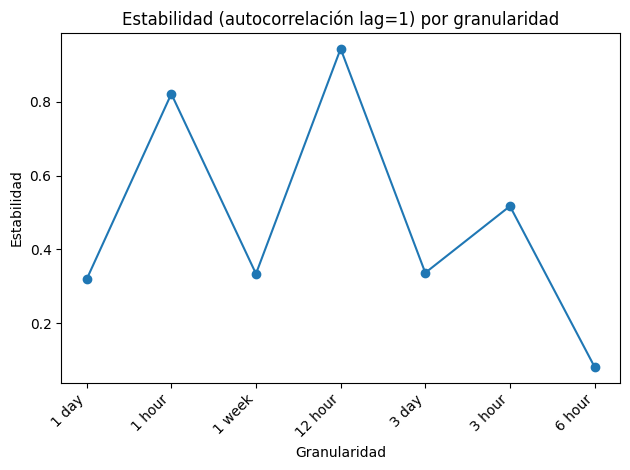

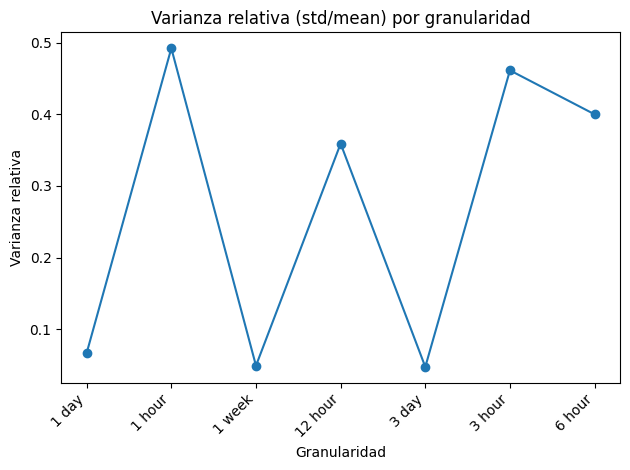

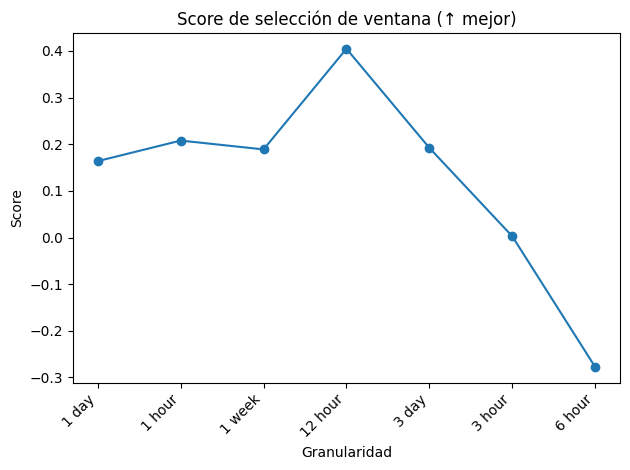

In [11]:
# a) Estabilidad vs Granularidad
plt.figure()
plt.plot(df_eval_scored["granularity"], df_eval_scored["stability"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("Estabilidad (autocorrelación lag=1) por granularidad")
plt.xlabel("Granularidad")
plt.ylabel("Estabilidad")
plt.tight_layout()
plt.show()

# b) Varianza relativa vs Granularidad
plt.figure()
plt.plot(df_eval_scored["granularity"], df_eval_scored["variance_ratio"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("Varianza relativa (std/mean) por granularidad")
plt.xlabel("Granularidad")
plt.ylabel("Varianza relativa")
plt.tight_layout()
plt.show()

# c) Score combinado
plt.figure()
plt.plot(df_eval_scored["granularity"], df_eval_scored["score"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("Score de selección de ventana (↑ mejor)")
plt.xlabel("Granularidad")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


La versión gráfica del score muestra la clara preferencia por la ventana de 12 horas

Ventana sugerida: 12 hour
Total ventanas: 641
Spikes (n_tx) con |z| >= 3.0: 0
Spikes (total_amount) con |z| >= 3.0: 0


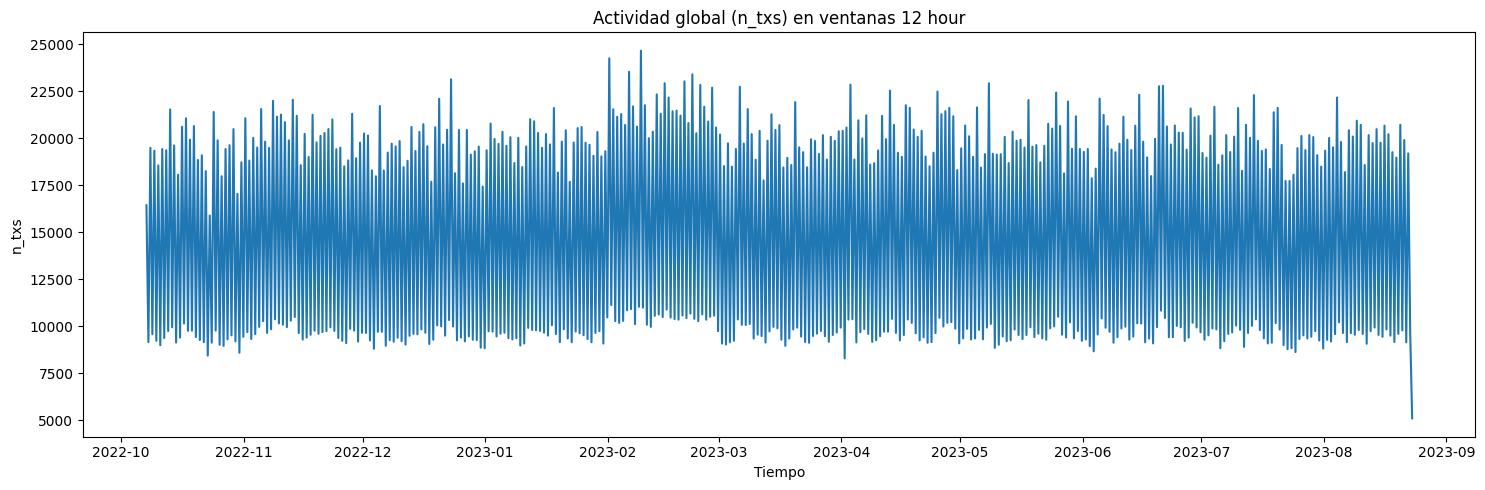

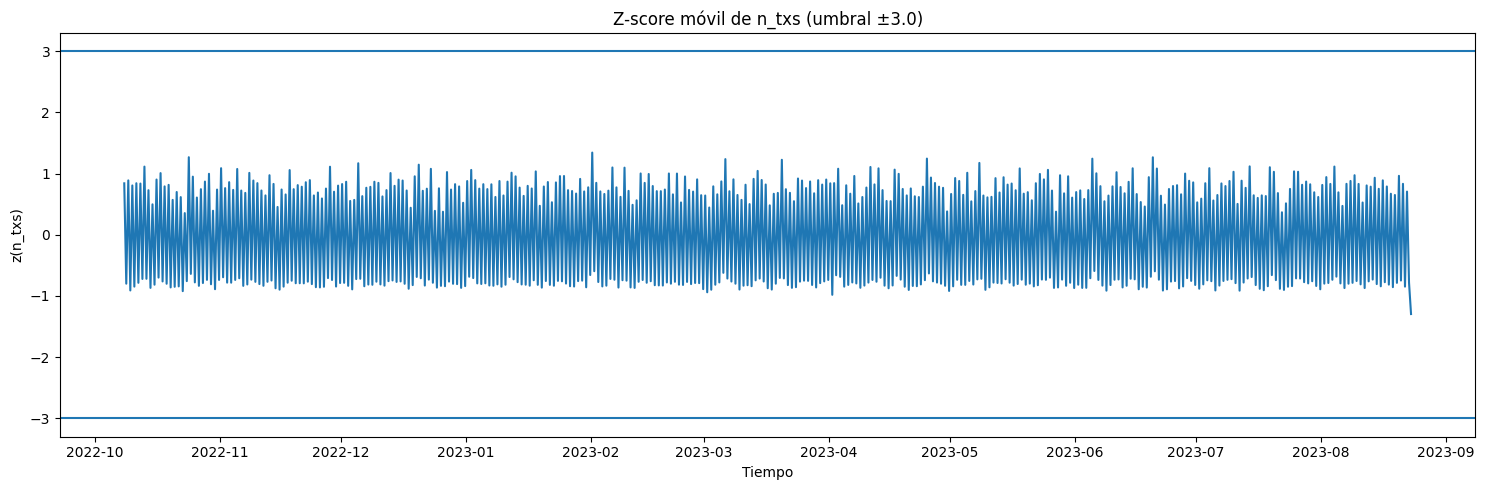

In [14]:
#Serie en la mejor ventana y detección de spikes

best_agg_sdf = agg_by_g[best_window]
best_pdf = best_agg_sdf.toPandas().sort_values("start").reset_index(drop=True)
best_pdf["start"] = pd.to_datetime(best_pdf["start"])
best_pdf["end"]   = pd.to_datetime(best_pdf["end"])

# Función de z-score rolling (para robustecer contra no-estacionariedad)
def rolling_zscore(x: pd.Series, window:int=7) -> pd.Series:
    # mean y std móviles; evitar valores iniciales NaN hasta que haya ventana suficiente
    roll_mean = x.rolling(window=window, min_periods=max(2, window//2)).mean()
    roll_std  = x.rolling(window=window, min_periods=max(2, window//2)).std(ddof=1)
    z = (x - roll_mean) / roll_std
    return z

# Calculamos z-score móvil sobre n_tx y total_amount
for col in ["n_txs", "total_amount"]:
    best_pdf[f"z_{col}"] = rolling_zscore(best_pdf[col].astype(float), window=7)

# Umbral de spike (ajustable). 3 es estándar; para datos muy ruidosos, 3.5–4.
Z_THR = 3.0

spikes_tx = best_pdf[np.abs(best_pdf["z_n_txs"]) >= Z_THR].copy()
spikes_amt = best_pdf[np.abs(best_pdf["z_total_amount"]) >= Z_THR].copy()

print(f"Ventana sugerida: {best_window}")
print(f"Total ventanas: {len(best_pdf)}")
print(f"Spikes (n_tx) con |z| >= {Z_THR}: {len(spikes_tx)}")
print(f"Spikes (total_amount) con |z| >= {Z_THR}: {len(spikes_amt)}")

# Gráficos de la serie y z-score (n_tx)
plt.figure(figsize=(15, 5))
plt.plot(best_pdf["start"], best_pdf["n_txs"])
plt.title(f"Actividad global (n_txs) en ventanas {best_window}")
plt.xlabel("Tiempo")
plt.ylabel("n_txs")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(best_pdf["start"], best_pdf["z_n_txs"])
plt.axhline(Z_THR)
plt.axhline(-Z_THR)
plt.title(f"Z-score móvil de n_txs (umbral ±{Z_THR})")
plt.xlabel("Tiempo")
plt.ylabel("z(n_txs)")
plt.tight_layout()
plt.show()

## HUBs

Se busca hacer análisis de series de tiempo de cuatro nodos, en particular deben ser hubs con alta cantidad de transferencias. Se requiere de dos pares de nodos con bajo porcentaje de transferencias fraudulentas, y otros dos con alto porcentaje. Para cada par un elemento tiene que ser hub en transferencias de salida, y el otro de entrada. Se analizarán patrones como periodicidad y estacionalidad. La ventana de tiempo no es completamente necesaria, pero sí útil.

In [23]:
df_sender_hubs = (
    df_txs
    .groupBy(F.col('sender_account'))
    .agg(
        F.count('*').alias('n_transfers'),
        F.sum(F.when(F.col('is_laundering') == 1, 1).otherwise(0)).alias('n_laundering'),
        F.sum(F.when(F.col('is_laundering') == 0, 1).otherwise(0)).alias('n_not_laundering')
    )
    .withColumn(
        'pct_laundering',
        F.round((F.col('n_laundering') / F.col('n_transfers')) * 100, 2)
    )
    .withColumn(
        'pct_not_laundering',
        F.round((F.col('n_not_laundering') / F.col('n_transfers')) * 100, 2)
    )
)

df_receiver_hubs = (
    df_txs
    .groupBy(F.col('receiver_account'))
    .agg(
        F.count('*').alias('n_transfers'),
        F.sum(F.when(F.col('is_laundering') == 1, 1).otherwise(0)).alias('n_laundering'),
        F.sum(F.when(F.col('is_laundering') == 0, 1).otherwise(0)).alias('n_not_laundering')
    )
    .withColumn(
        'pct_laundering',
        F.round((F.col('n_laundering') / F.col('n_transfers')) * 100, 2)
    )
    .withColumn(
        'pct_not_laundering',
        F.round((F.col('n_not_laundering') / F.col('n_transfers')) * 100, 2)
    )
)

In [41]:
top_sender_laundering_hub = df_sender_hubs \
    .orderBy(
        F.desc('pct_laundering'),
        F.desc('n_transfers')
        ) \
    .collect()[2]['sender_account'] #Se priorizó un hub con un número de transferencias "alto"

df_sender_hubs \
    .orderBy(
        F.desc('pct_laundering'),
        F.desc('n_transfers'),
        ) \
    .show()

[Stage 294:====================================================>  (61 + 3) / 64]

+--------------+-----------+------------+----------------+--------------+------------------+
|sender_account|n_transfers|n_laundering|n_not_laundering|pct_laundering|pct_not_laundering|
+--------------+-----------+------------+----------------+--------------+------------------+
|    5917350547|          9|           9|               0|         100.0|               0.0|
|    2247370907|         24|          23|               1|         95.83|              4.17|
|    4159678387|         40|          37|               3|          92.5|               7.5|
|    2488893433|         29|          26|               3|         89.66|             10.34|
|    5008453588|         28|          25|               3|         89.29|             10.71|
|    3864360347|         23|          20|               3|         86.96|             13.04|
|    1865451606|         28|          24|               4|         85.71|             14.29|
|    4220180108|          7|           6|               1|         85.

In [43]:
top_receiver_laundering_hub = df_receiver_hubs \
    .orderBy(
        F.desc('pct_laundering'),
        F.desc('n_transfers')
        ) \
    .collect()[0]['receiver_account']

df_receiver_hubs \
    .orderBy(
        F.desc('pct_laundering'),
        F.desc('n_transfers'),
        ) \
    .show()

[Stage 316:================================================>      (56 + 8) / 64]

+----------------+-----------+------------+----------------+--------------+------------------+
|receiver_account|n_transfers|n_laundering|n_not_laundering|pct_laundering|pct_not_laundering|
+----------------+-----------+------------+----------------+--------------+------------------+
|        57359957|         26|          26|               0|         100.0|               0.0|
|      4465839311|         24|          24|               0|         100.0|               0.0|
|      3282818329|         23|          23|               0|         100.0|               0.0|
|      7748494288|         23|          23|               0|         100.0|               0.0|
|      4810948357|         20|          20|               0|         100.0|               0.0|
|        86715269|         18|          18|               0|         100.0|               0.0|
|      5200865572|         16|          16|               0|         100.0|               0.0|
|      3474569692|         13|          13|       

In [44]:
cleanest_sender_hub = df_sender_hubs \
    .orderBy(
        F.asc('pct_laundering'),
        F.desc('n_transfers')
        ) \
    .collect()[0]['sender_account']

df_sender_hubs \
    .orderBy(
        F.asc('pct_laundering'),
        F.desc('n_transfers'),
        ) \
    .show()

[Stage 327:=================================================>     (58 + 6) / 64]

+--------------+-----------+------------+----------------+--------------+------------------+
|sender_account|n_transfers|n_laundering|n_not_laundering|pct_laundering|pct_not_laundering|
+--------------+-----------+------------+----------------+--------------+------------------+
|    3831533348|        749|           0|             749|           0.0|             100.0|
|     798082205|        743|           0|             743|           0.0|             100.0|
|    5435316010|        731|           0|             731|           0.0|             100.0|
|    4724445469|        731|           0|             731|           0.0|             100.0|
|    4109275762|        720|           0|             720|           0.0|             100.0|
|     244442078|        713|           0|             713|           0.0|             100.0|
|    4492659500|        712|           0|             712|           0.0|             100.0|
|    4924631375|        706|           0|             706|           0

In [46]:
cleanest_receiver_hub = df_receiver_hubs \
    .orderBy(
        F.asc('pct_laundering'),
        F.desc('n_transfers')
        ) \
    .collect()[0]['receiver_account']

df_receiver_hubs \
    .orderBy(
        F.asc('pct_laundering'),
        F.desc('n_transfers'),
        ) \
    .show()

[Stage 349:==================================================>    (59 + 5) / 64]

+----------------+-----------+------------+----------------+--------------+------------------+
|receiver_account|n_transfers|n_laundering|n_not_laundering|pct_laundering|pct_not_laundering|
+----------------+-----------+------------+----------------+--------------+------------------+
|      8600542721|        751|           0|             751|           0.0|             100.0|
|      2938210715|        745|           0|             745|           0.0|             100.0|
|      5460360634|        740|           0|             740|           0.0|             100.0|
|      5579295130|        739|           0|             739|           0.0|             100.0|
|      4808614002|        737|           0|             737|           0.0|             100.0|
|      4724445469|        736|           0|             736|           0.0|             100.0|
|      9544431251|        734|           0|             734|           0.0|             100.0|
|      4924631375|        734|           0|       

In [53]:
#Dataframes que corresponden a las transacciones entrada/salida de esos hubs
hubs = [
    ('ts_top_sender_laundering_activity', top_sender_laundering_hub),
    ('ts_top_receiver_laundering_activity', top_receiver_laundering_hub),
    ('ts_cleanest_sender_activity', cleanest_sender_hub),
    ('ts_cleanest_receiver_activity', cleanest_receiver_hub)
]

def build_ts_for_hub(df, hub_value):
    hub_lit = F.lit(hub_value)

    return (
        df
        .filter(
            (F.col('sender_account') == hub_lit) |
            (F.col('receiver_account') == hub_lit)
        )
        .withColumn(
            'signed_amount',
            F.when(F.col('receiver_account') == hub_lit,  F.col('amount'))
             .when(F.col('sender_account') == hub_lit, -F.col('amount'))
        )
        .select(
            'date_time',
            'signed_amount'
        )
        .orderBy('date_time')
    )

ts_dict_spark = {}

for ts_name, hub in hubs:
    ts_dict_spark[ts_name] = build_ts_for_hub(df_txs, hub)


In [54]:
# Convertimos todas las series a Darts TimeSeries
ts_dict_darts = {}

for ts_name, df_spark in ts_dict_spark.items():
    ts_dict_darts[ts_name] = spark_df_to_darts_ts(
        df_spark,
        time_col="date_time",
        value_col="signed_amount",
        freq=None  # cámbialo a 'D', 'H', etc. si tu serie es regular
    )

ERROR:darts.timeseries:ValueError: The time index is missing the `freq` attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with missing dates. If you know the actual frequency, try setting `fill_missing_dates=True, freq=actual_frequency`. If not, try setting `fill_missing_dates=True, freq=None` to see if a frequency can be inferred.


ValueError: The time index is missing the `freq` attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with missing dates. If you know the actual frequency, try setting `fill_missing_dates=True, freq=actual_frequency`. If not, try setting `fill_missing_dates=True, freq=None` to see if a frequency can be inferred.

In [51]:
#Convertir de Spark dataframe a TimeSeries de Darts

def spark_df_to_darts_ts(
    df_spark,
    time_col="date_time",
    value_col="signed_amount",
    freq=None
):
    """
    Convierte un DataFrame PySpark con columnas (time_col, value_col)
    a un objeto darts.TimeSeries.
    
    - freq: string tipo 'D', 'H', 'T', etc. Si la serie es estrictamente regular,
      puedes fijar la frecuencia; si no, puedes dejar freq=None y que Darts la infiera.
    """
    # Pasar a pandas
    pdf = df_spark.toPandas()

    # Asegurar tipo datetime y orden temporal
    pdf[time_col] = pd.to_datetime(pdf[time_col])
    pdf = pdf.sort_values(time_col)

    # Opcional: establecer índice de tiempo
    pdf.set_index(time_col, inplace=True)

    # Construir TimeSeries
    # Usamos from_times_and_values para explicitar times
    ts = TimeSeries.from_times_and_values(
        times=pdf.index,
        values=pdf[[value_col]].values,  # 2D
        freq=freq  # puede ser None, 'D', 'H', etc.
    )

    return ts

# Convertimos todas las series a Darts TimeSeries
ts_dict_darts = {}

for ts_name, df_spark in ts_dict_spark.items():
    ts_dict_darts[ts_name] = spark_df_to_darts_ts(
        df_spark,
        time_col="date_time",
        value_col="signed_amount",
        freq=None  # cámbialo a 'D', 'H', etc. si tu serie es regular
    )


NameError: name 'ts_dict_spark' is not defined

## EDA Temporal